In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
from datetime import datetime, date
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

import geopandas
import branca.colormap as cm
from branca.element import Template, MacroElement
import folium
from folium import plugins

In [2]:
# mac os
font_path = '/Library/Fonts/simhei.ttf'
fontP = font_manager.FontProperties(fname=font_path)
fontP.set_size(14)
fontP_12 = font_manager.FontProperties(fname=font_path)
fontP_12.set_size(12)


## Import datasets

In [3]:
dose1_df = pd.read_csv('datasets/Reactions Pfizer-BioNTech COVID-19 Vaccine - dose1.csv')
dose2_df = pd.read_csv('datasets/Reactions Pfizer-BioNTech COVID-19 Vaccine - dose2.csv')


In [4]:
dose_df = pd.merge(dose1_df, dose2_df, on=['age', 'local_or_system', 'reaction', 'degree',
                                           'local_or_system_cn', 'reaction_cn', 'degree_cn'])

dose_df = dose_df.sort_values(['age', 'reaction']).sort_values('dose1_pct',
                                                               ascending=True).reset_index(drop=True)

## Visualisation

### Global

In [5]:
any_local_reactions_df = dose_df[(dose_df['local_or_system_cn'] == '局部反应') &
                                 (dose_df['degree_cn'] == '任意程度')].reset_index(drop=True)
any_systemic_reactions_df = dose_df[(dose_df['local_or_system_cn'] == '全身反应') &
                                 (dose_df['degree_cn'] == '任意程度')].reset_index(drop=True)

# any_reactions_df = dose_df[dose_df['degree_cn'] == '任意程度'].reset_index(drop=True)

In [6]:
def viz_glb_reactions(axarr, df, width, title, age_segment, reaction_nb, x_lim_max):
    axarr.set_title(title, fontproperties=fontP)
    barh1 = axarr.barh(np.arange(reaction_nb) + 1/2 * width,
               df[df['age'] == age_segment]['dose1_pct'],
               height=width)
    barh2 = axarr.barh(np.arange(reaction_nb) - 1/2 * width,
               df[df['age'] == age_segment]['dose2_pct'],
               height=width)
    axarr.tick_params(axis='x', labelsize=12)
    axarr.set_xlim(0, x_lim_max)
    axarr.set_xlabel('百分比（%）', size=12, fontproperties=fontP)
    axarr.set_yticks(np.arange(reaction_nb))
    axarr.set_yticklabels(df[df['age'] == age_segment]['reaction_cn'], fontproperties=fontP)

    axarr.legend(handles=(barh1, barh2),
                 labels=('第一针', '第二针'),
                 loc=4, prop=fontP)
    axarr.grid(which='major', axis='x', alpha=0.5)

    

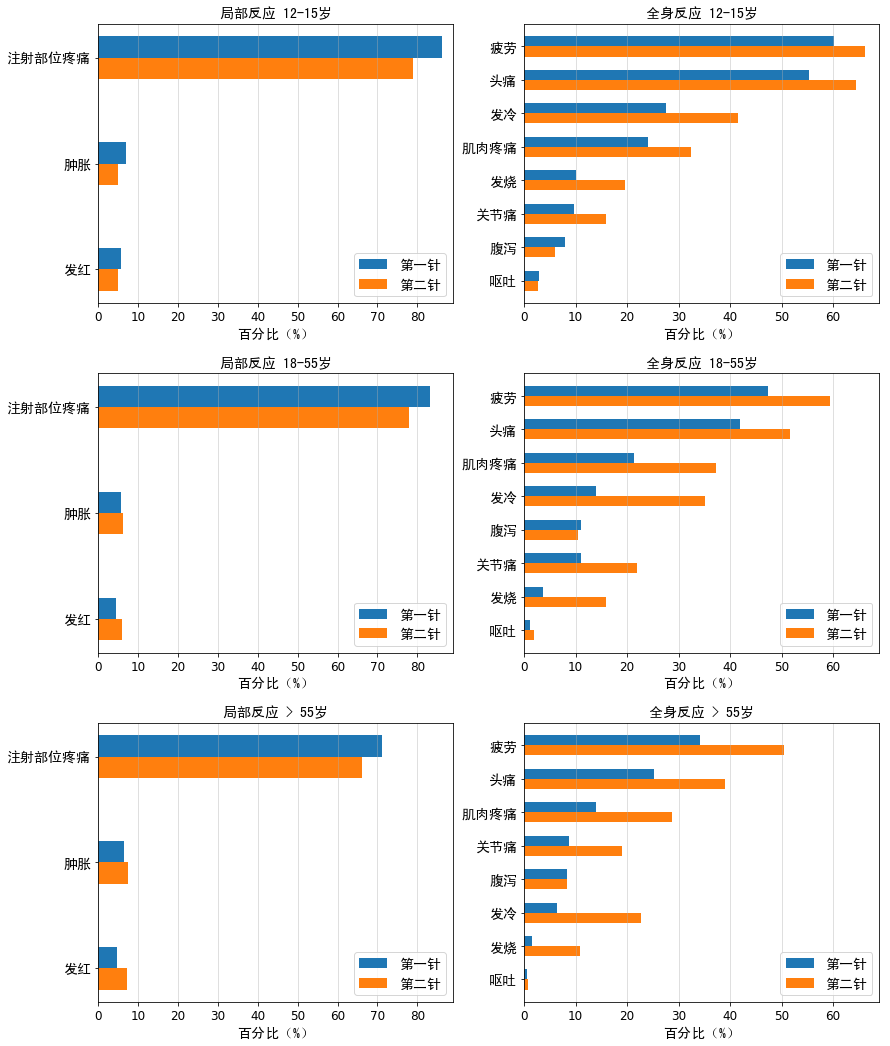

In [7]:
fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
width_1 = 0.2
width_2 = 0.3

viz_glb_reactions(axarr[0, 0], df=any_local_reactions_df, width=width_1,
                  title='局部反应 12-15岁', age_segment='12-15 years', reaction_nb=3, x_lim_max=89)
viz_glb_reactions(axarr[1, 0], df=any_local_reactions_df, width=width_1,
                  title='局部反应 18-55岁', age_segment='18-55 years', reaction_nb=3, x_lim_max=89)
viz_glb_reactions(axarr[2, 0], df=any_local_reactions_df, width=width_1,
                  title='局部反应 > 55岁', age_segment='> 55 years', reaction_nb=3, x_lim_max=89)

viz_glb_reactions(axarr[0, 1], df=any_systemic_reactions_df, width=width_2,
                  title='全身反应 12-15岁', age_segment='12-15 years', reaction_nb=8, x_lim_max=69)
viz_glb_reactions(axarr[1, 1], df=any_systemic_reactions_df, width=width_2,
                  title='全身反应 18-55岁', age_segment='18-55 years', reaction_nb=8, x_lim_max=69)
viz_glb_reactions(axarr[2, 1], df=any_systemic_reactions_df, width=width_2,
                  title='全身反应 > 55岁', age_segment='> 55 years', reaction_nb=8, x_lim_max=69)

plt.subplots_adjust(hspace=0.25)


### Details

In [48]:
def viz_detail_reactions(axarr_left, axarr_right, df, reaction, degree_nb, width, x_lim_max):
    reaction_df = df[(df['reaction_cn'] == reaction) & (df['degree_cn'] != '任意程度')]
    
    # second dose
    axarr_left.set_yticklabels([])
    axarr_left.set_yticks([])
    axarr_left.invert_yaxis()
    axarr_left.invert_xaxis()
    axarrL_2 = axarr_left.twinx()
    barh_l1 = axarrL_2.barh(np.arange(degree_nb) +  width,
                            reaction_df[reaction_df['age'] == '12-15 years']['dose2_pct'],
                            height=width)
    barh_l2 = axarrL_2.barh(np.arange(degree_nb),
                            reaction_df[reaction_df['age'] == '18-55 years']['dose2_pct'],
                            height=width)
    barh_l3 = axarrL_2.barh(np.arange(degree_nb) -  width,
                            reaction_df[reaction_df['age'] == '> 55 years']['dose2_pct'],
                            height=width)

    axarr_left.tick_params(axis='x', labelsize=13)
    axarrL_2.set_xlim(x_lim_max, 0)
    axarr_left.xaxis.tick_top()
    axarr_left.xaxis.set_label_position('top')
    axarr_left.set_xlabel('第二针: %s（百分比）' % reaction, size=13, labelpad=10, fontproperties=fontP)
    axarrL_2.set_yticklabels([])
    axarr_left.grid(which='major', axis='x', alpha=0.5)

    # first dose
    barh_r1 = axarr_right.barh(np.arange(degree_nb) +  width,
                               reaction_df[reaction_df['age'] == '12-15 years']['dose1_pct'],
                               height=width)
    barh_r2 = axarr_right.barh(np.arange(degree_nb),
                               reaction_df[reaction_df['age'] == '18-55 years']['dose1_pct'],
                               height=width)
    barh_r3 = axarr_right.barh(np.arange(degree_nb) -  width,
                               reaction_df[reaction_df['age'] == '> 55 years']['dose1_pct'],
                               height=width)

    axarr_right.tick_params(axis='x', labelsize=13)
    axarr_right.set_xlim(0, x_lim_max)
    axarr_right.xaxis.tick_top()
    axarr_right.xaxis.set_label_position('top')
    axarr_right.set_xlabel('第一针: %s（百分比）' % reaction, size=13, labelpad=10, fontproperties=fontP)
    axarr_right.set_yticks(np.arange(4))
    axarr_right.set_yticklabels(reaction_df[reaction_df['age'] == '> 55 years']['degree_cn'],
                                fontproperties=fontP)
    axarr_right.grid(which='major', axis='x', alpha=0.5)
    axarr_right.legend(handles=(barh_r1, barh_r2, barh_r3),
                       labels=('12-15岁', '18-55岁', '> 55岁' ),
                       loc=4, prop=fontP)



In [36]:
dose_df

,age,local_or_system,reaction,degree,local_or_system_cn,reaction_cn,degree_cn,dose1_total_nb,dose1_nb,dose1_pct,dose2_total_nb,dose2_nb,dose2_pct
0,> 55 years,Systemic Reactions,Vomiting,Grade 4,全身反应,呕吐,极严重,1802,0,0.0,1660,0,0.0
1,12-15 years,Systemic Reactions,New or worsening muscle pain,Grade 4,全身反应,肌肉疼痛,极严重,1127,0,0.0,1097,0,0.0
2,> 55 years,Systemic Reactions,Headache,Grade 4,全身反应,头痛,极严重,1802,0,0.0,1660,0,0.0
3,12-15 years,Local Reactions,Pain at the injection site,Grade 4,局部反应,注射部位疼痛,极严重,1127,0,0.0,1097,0,0.0
4,12-15 years,Local Reactions,Redness,Grade 4,局部反应,发红,极严重,1127,0,0.0,1097,0,0.0
5,12-15 years,Local Reactions,Swelling,Grade 4,局部反应,肿胀,极严重,1127,0,0.0,1097,0,0.0
6,12-15 years,Systemic Reactions,Vomiting,Moderate,全身反应,呕吐,中度的,1127,0,0.0,1097,4,0.4
7,12-15 years,Systemic Reactions,Vomiting,Grade 4,全身反应,呕吐,极严重,1127,0,0.0,1097,0,0.0
8,> 55 years,Systemic Reactions,Fatigue,Grade 4,全身反应,疲劳,极严重,1802,0,0.0,1660,0,0.0
9,18-55 years,Systemic Reactions,Chills,Grade 4,全身反应,发冷,极严重,2291,0,0.0,2098,0,0.0


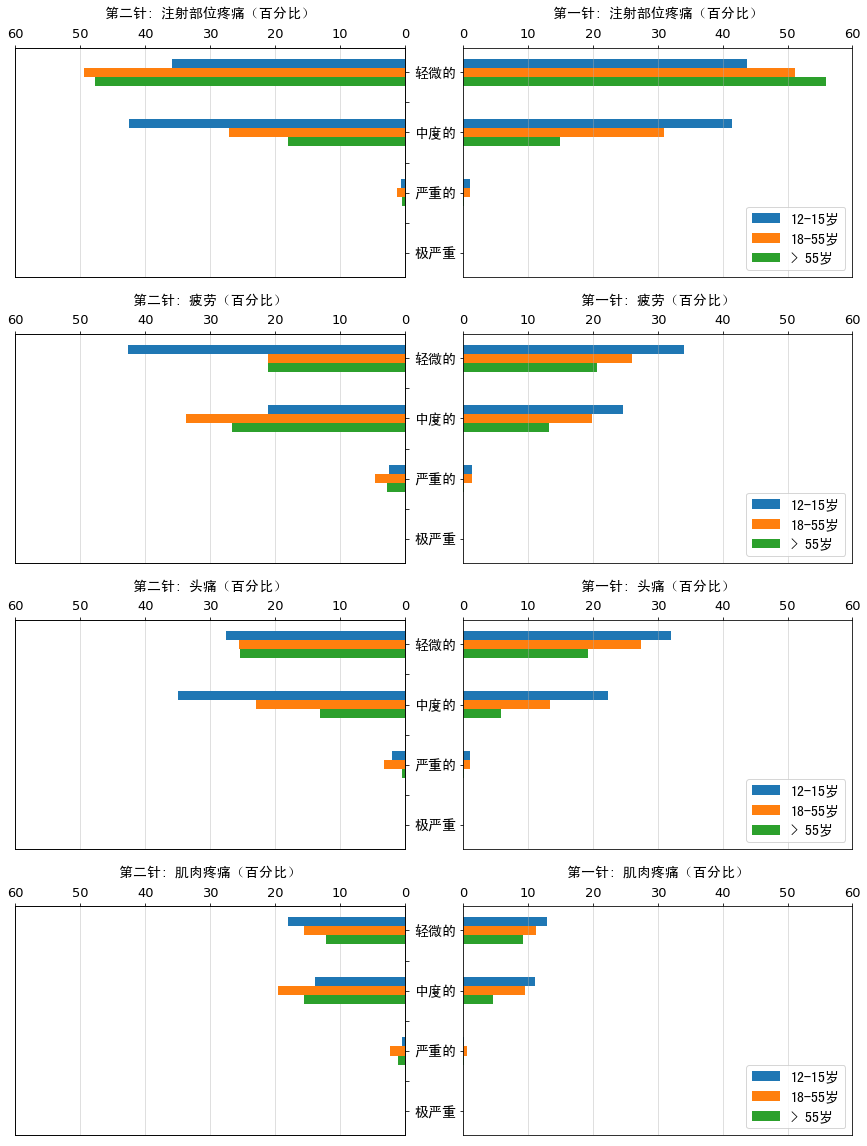

In [56]:
fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

viz_detail_reactions(axarr_left=axarr[0, 0], axarr_right=axarr[0, 1], df=dose_df,
                     reaction='注射部位疼痛', degree_nb=4, width=0.15, x_lim_max=60)
viz_detail_reactions(axarr_left=axarr[1, 0], axarr_right=axarr[1, 1], df=dose_df,
                     reaction='疲劳', degree_nb=4, width=0.15, x_lim_max=60)
viz_detail_reactions(axarr_left=axarr[2, 0], axarr_right=axarr[2, 1], df=dose_df,
                     reaction='头痛', degree_nb=4, width=0.15, x_lim_max=60)
viz_detail_reactions(axarr_left=axarr[3, 0], axarr_right=axarr[3, 1], df=dose_df,
                     reaction='肌肉疼痛', degree_nb=4, width=0.15, x_lim_max=60)

plt.subplots_adjust(wspace=0.15, hspace=0.25)


In [13]:
# fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
# width = 0.7

# axarr[0].bar(any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '注射部位疼痛'].index - width * 3/2,
#              any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '注射部位疼痛'].dose1_pct,
#                 width)
# axarr[0].bar(any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '发红'].index - width * 3/2,
#              any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '发红'].dose1_pct,
#                 width)
# axarr[0].bar(any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '肿胀'].index - width * 3/2,
#              any_local_reactions_df[any_local_reactions_df['reaction_cn'] == '肿胀'].dose1_pct,
#                 width)
